In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    classification_report,
)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC

from ucimlrepo import fetch_ucirepo

### Data & Visulisation

4 classes multi-class classification

1728 instances

6 features -> 21 features

In [2]:
# fetch dataset
car = fetch_ucirepo(id=19)

# data (as pandas dataframes)
X = car.data.features

In [3]:
expanded_cols = []
X_numeric_pd = X.copy()
for col in X.columns:
    X_numeric_pd[col] = X_numeric_pd[col].astype("category").cat.codes

In [4]:
def custom_combiner(feature, category):
    # print(f"feature: {feature}")
    # print(f"category: {category}")
    if feature == "feature":
        return "test"
    feature_og_name_dict = dict(
        enumerate(X[feature].astype("category").cat.categories)
    )
    return f"{feature}={feature_og_name_dict[category]}"


ohe = OneHotEncoder(drop="if_binary", feature_name_combiner=custom_combiner)
X_oh_np = ohe.fit_transform(X_numeric_pd.to_numpy()).toarray()
feature_names = ohe.get_feature_names_out(
    input_features=X_numeric_pd.columns.to_list()
)

print(X_oh_np.shape)
print(feature_names)


# convert categorical target to numerical
le = LabelEncoder()
y_np = le.fit_transform(car.data.targets.to_numpy().flatten())
print(y_np.shape)
print(le.classes_.tolist())

(1728, 21)
['buying=high' 'buying=low' 'buying=med' 'buying=vhigh' 'maint=high'
 'maint=low' 'maint=med' 'maint=vhigh' 'doors=2' 'doors=3' 'doors=4'
 'doors=5more' 'persons=2' 'persons=4' 'persons=more' 'lug_boot=big'
 'lug_boot=med' 'lug_boot=small' 'safety=high' 'safety=low' 'safety=med']
(1728,)
['acc', 'good', 'unacc', 'vgood']


In [5]:
train_X, hold_out_test_X, train_y, hold_out_test_y = train_test_split(
    X_oh_np, y_np, test_size=0.2, random_state=73, stratify=y_np
)

In [6]:
np.bincount(train_y), np.bincount(hold_out_test_y)

(array([307,  55, 968,  52]), array([ 77,  14, 242,  13]))

### Common code

In [7]:
# Config
NUM_FOLD = 5
RANDOM_STATE = 73

In [8]:
def get_fold_print_string(fold_result: list[float]):
    mean = np.mean(fold_result)
    ste = np.std(fold_result) / np.sqrt(NUM_FOLD)
    return f"{mean:.3f} ± {ste:.3f}"

In [9]:
def multiclass_classification(
    model,
    model_name: str,
    n_splits: int = NUM_FOLD,
    random_state: int = RANDOM_STATE,
):
    print(f"Model {model_name} with {n_splits}-fold cross-validation\n")
    skf = StratifiedKFold(
        n_splits=n_splits, shuffle=True, random_state=random_state
    )

    fold_accuracy = []

    hold_out_accuracy = []

    fig, ax = plt.subplots(1, 5, figsize=(15, 4))
    for i, (train_index, test_index) in enumerate(skf.split(train_X, train_y)):
        model.fit(train_X[train_index], train_y[train_index])

        y_pred = model.predict(train_X[test_index])

        acc = accuracy_score(train_y[test_index], y_pred)
        fold_accuracy.append(acc)

        print(
            classification_report(
                train_y[test_index], y_pred, target_names=le.classes_
            )
        )

        # Test on hold-out test set
        y_hold_out_pred = model.predict(hold_out_test_X)

        acc = accuracy_score(hold_out_test_y, y_hold_out_pred)
        hold_out_accuracy.append(acc)
        print("Hold-out Test")
        print(
            classification_report(
                hold_out_test_y, y_hold_out_pred, target_names=le.classes_
            )
        )

        # Plot confusion matrix
        cm = confusion_matrix(train_y[test_index], y_pred)
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm, display_labels=model.classes_
        )
        disp.plot(ax=ax[i], xticks_rotation=45)
        ax[i].set_title(f"Fold {i}")

    print("\nCross-Validation Results:")
    print(f"Mean Accuracy: {get_fold_print_string(fold_accuracy)}")

    print("\nHold-out Test Results:")
    print(f"Mean Accuracy: {get_fold_print_string(hold_out_accuracy)}")

    plt.tight_layout()

## Logistic regression

Model Logistic Regression with 5-fold cross-validation

              precision    recall  f1-score   support

         acc       0.78      0.84      0.81        61
        good       0.57      0.36      0.44        11
       unacc       0.96      0.95      0.95       194
       vgood       0.69      0.82      0.75        11

    accuracy                           0.90       277
   macro avg       0.75      0.74      0.74       277
weighted avg       0.89      0.90      0.89       277

Hold-out Test
              precision    recall  f1-score   support

         acc       0.75      0.82      0.78        77
        good       0.54      0.50      0.52        14
       unacc       0.96      0.94      0.95       242
       vgood       0.92      0.92      0.92        13

    accuracy                           0.89       346
   macro avg       0.79      0.79      0.79       346
weighted avg       0.90      0.89      0.89       346

              precision    recall  f1-score   support

     

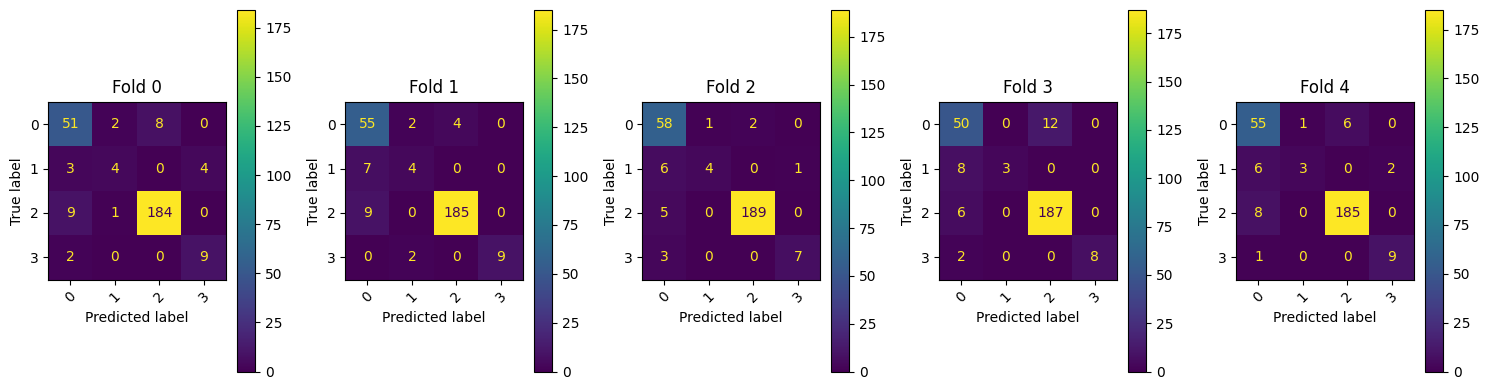

In [10]:
model = LogisticRegression(solver="saga")
multiclass_classification(model, "Logistic Regression")

## Random forest

Model Random Forest with 5-fold cross-validation

              precision    recall  f1-score   support

         acc       0.89      0.97      0.93        61
        good       0.86      0.55      0.67        11
       unacc       0.99      0.98      0.99       194
       vgood       0.69      0.82      0.75        11

    accuracy                           0.95       277
   macro avg       0.86      0.83      0.83       277
weighted avg       0.96      0.95      0.95       277

Hold-out Test
              precision    recall  f1-score   support

         acc       0.89      0.92      0.90        77
        good       0.69      0.79      0.73        14
       unacc       0.99      0.97      0.98       242
       vgood       0.92      0.85      0.88        13

    accuracy                           0.95       346
   macro avg       0.87      0.88      0.87       346
weighted avg       0.95      0.95      0.95       346

              precision    recall  f1-score   support

         ac

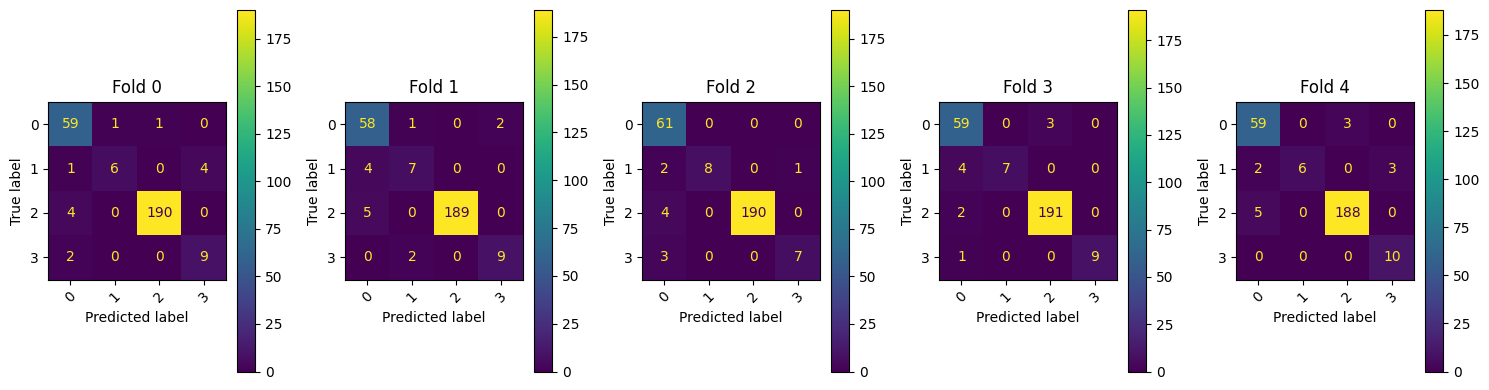

In [11]:
model = RandomForestClassifier(n_estimators=100, random_state=75)
multiclass_classification(model, "Random Forest")

## SVM

Model SVM with 5-fold cross-validation

              precision    recall  f1-score   support

         acc       0.79      0.98      0.88        61
        good       0.92      1.00      0.96        11
       unacc       1.00      0.92      0.96       194
       vgood       1.00      1.00      1.00        11

    accuracy                           0.94       277
   macro avg       0.93      0.98      0.95       277
weighted avg       0.95      0.94      0.94       277

Hold-out Test
              precision    recall  f1-score   support

         acc       0.79      0.95      0.86        77
        good       0.68      0.93      0.79        14
       unacc       1.00      0.91      0.95       242
       vgood       0.93      1.00      0.96        13

    accuracy                           0.92       346
   macro avg       0.85      0.95      0.89       346
weighted avg       0.94      0.92      0.93       346

              precision    recall  f1-score   support

         acc       0.

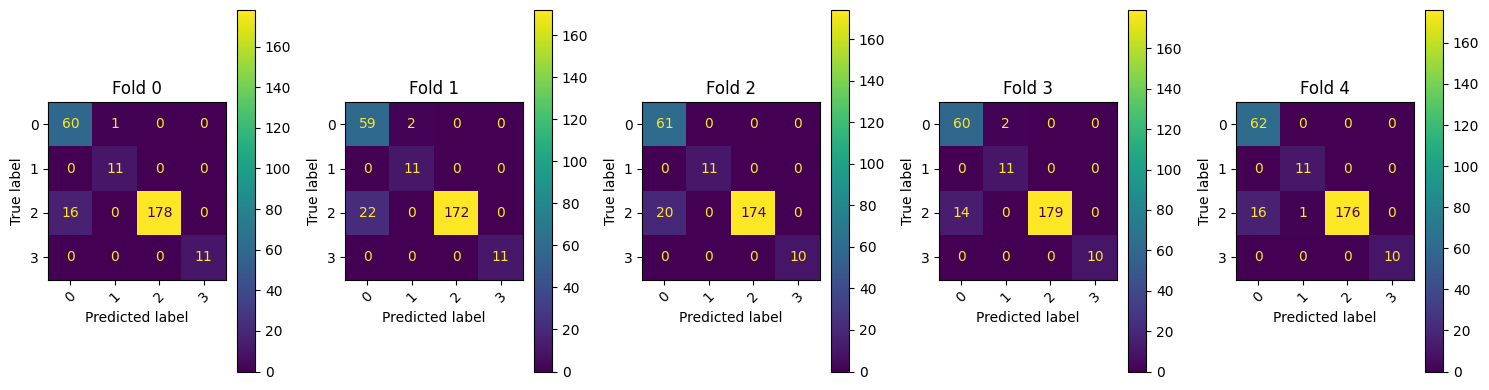

In [12]:
model = SVC(kernel="rbf", random_state=76, class_weight="balanced")
multiclass_classification(model, "SVM")

## Decision tree

In [13]:
# Function to calculate the average depth of the decision tree
def average_tree_depth(tree):
    def _recursive_depth(node, current_depth, depths):
        if (
            tree.children_left[node] == tree.children_right[node]
        ):  # It's a leaf node
            depths.append(current_depth)
            return
        _recursive_depth(tree.children_left[node], current_depth + 1, depths)
        _recursive_depth(tree.children_right[node], current_depth + 1, depths)

    depths = []
    _recursive_depth(0, 0, depths)  # Start from the root node (index 0)
    return sum(depths) / len(depths)


# Function to count the number of branches (internal nodes)
def count_branches(tree):
    n_nodes = tree.node_count  # Total number of nodes in the tree
    n_leaves = tree.n_leaves  # Total number of leaf nodes
    n_branches = n_nodes - n_leaves  # Number of internal nodes (branches)
    return n_branches

Decision tree with 5-fold cross-validation

              precision    recall  f1-score   support

         acc       0.91      0.84      0.87        61
        good       1.00      0.82      0.90        11
       unacc       0.96      0.99      0.97       194
       vgood       0.91      0.91      0.91        11

    accuracy                           0.95       277
   macro avg       0.94      0.89      0.91       277
weighted avg       0.95      0.95      0.94       277

Hold-out Test
              precision    recall  f1-score   support

         acc       0.86      0.90      0.88        77
        good       0.86      0.86      0.86        14
       unacc       0.97      0.96      0.96       242
       vgood       1.00      0.85      0.92        13

    accuracy                           0.94       346
   macro avg       0.92      0.89      0.90       346
weighted avg       0.94      0.94      0.94       346

              precision    recall  f1-score   support

         acc     

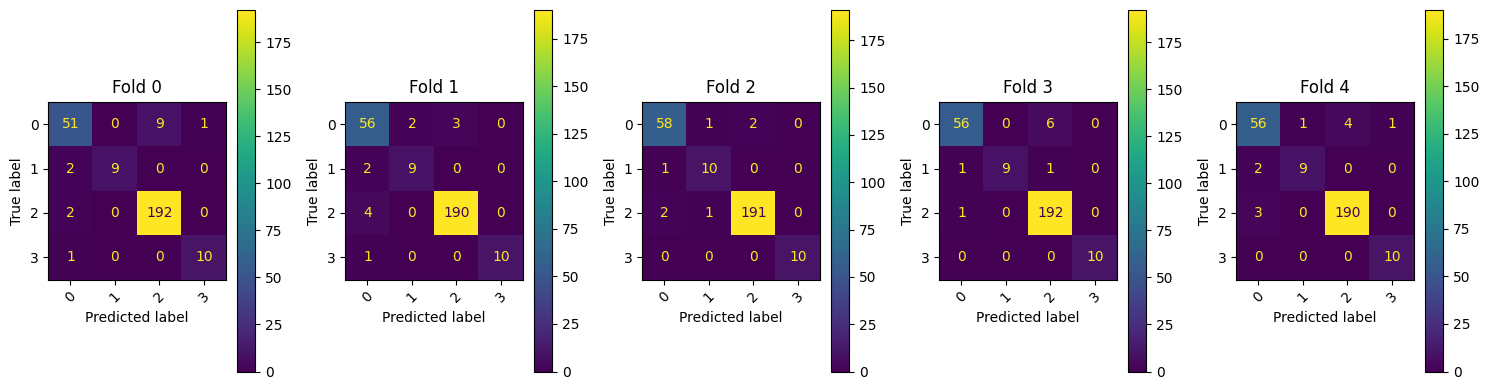

In [14]:
model = DecisionTreeClassifier(random_state=77, class_weight="balanced")
print(f"Decision tree with {NUM_FOLD}-fold cross-validation\n")
skf = StratifiedKFold(n_splits=NUM_FOLD, shuffle=True, random_state=77)

fold_accuracy = []
tree_stats: list[dict[str, float]] = []
hold_out_accuracy = []

fig, ax = plt.subplots(1, NUM_FOLD, figsize=(15, 4))
for i, (train_index, test_index) in enumerate(skf.split(train_X, train_y)):
    model.fit(train_X[train_index], train_y[train_index])

    y_pred = model.predict(train_X[test_index])

    acc = accuracy_score(train_y[test_index], y_pred)
    fold_accuracy.append(acc)

    max_depth = model.get_depth()
    avg_depth = average_tree_depth(model.tree_)
    n_branches = count_branches(model.tree_)

    tree_stats.append(
        {
            "max_depth": max_depth,
            "avg_depth": avg_depth,
            "n_branches": n_branches,
        }
    )

    print(
        classification_report(
            train_y[test_index], y_pred, target_names=le.classes_
        )
    )

    # Test on hold-out test set
    y_hold_out_pred = model.predict(hold_out_test_X)

    acc = accuracy_score(hold_out_test_y, y_hold_out_pred)
    hold_out_accuracy.append(acc)
    print("Hold-out Test")
    print(
        classification_report(
            hold_out_test_y, y_hold_out_pred, target_names=le.classes_
        )
    )

    # Plot confusion matrix
    cm = confusion_matrix(train_y[test_index], y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=model.classes_
    )
    disp.plot(ax=ax[i], xticks_rotation=45)
    ax[i].set_title(f"Fold {i}")

print("\nCross-Validation Results:")
print(f"Mean Accuracy: {get_fold_print_string(fold_accuracy)}")

print("\nHold-out Test Results:")
print(f"Mean Accuracy: {get_fold_print_string(hold_out_accuracy)}")

print(f"\nTree stats:")
print(
    f"Avg Max Depth: {get_fold_print_string([x['max_depth'] for x in tree_stats])}"
)
print(
    f"Avg Avg Depth: {get_fold_print_string([x['avg_depth'] for x in tree_stats])}"
)
print(
    f"Avg Branches: {get_fold_print_string([x['n_branches'] for x in tree_stats])}"
)

plt.tight_layout()

[Text(0.7207186259920635, 0.9642857142857143, 'safety=low <= 0.5\ngini = 0.75\nsamples = 1106\nvalue = [276.5, 276.5, 276.5, 276.5]'),
 Text(0.7127821180555556, 0.8928571428571429, 'persons=2 <= 0.5\ngini = 0.736\nsamples = 729\nvalue = [276.5, 276.5, 141.996, 276.5]'),
 Text(0.7167503720238095, 0.9285714285714286, 'True  '),
 Text(0.5668712797619048, 0.8214285714285714, 'safety=med <= 0.5\ngini = 0.703\nsamples = 484\nvalue = [276.5, 276.5, 54.586, 276.5]'),
 Text(0.298859126984127, 0.75, 'lug_boot=small <= 0.5\ngini = 0.65\nsamples = 251\nvalue = [154.614, 131.966, 18.195, 276.5]'),
 Text(0.19940476190476192, 0.6785714285714286, 'buying=high <= 0.5\ngini = 0.505\nsamples = 168\nvalue = [104.957, 31.42, 9.99, 276.5]'),
 Text(0.16865079365079366, 0.6071428571428571, 'maint=vhigh <= 0.5\ngini = 0.433\nsamples = 123\nvalue = [65.457, 31.42, 6.422, 276.5]'),
 Text(0.13095238095238096, 0.5357142857142857, 'buying=vhigh <= 0.5\ngini = 0.362\nsamples = 91\nvalue = [41.757, 31.42, 2.497, 276.

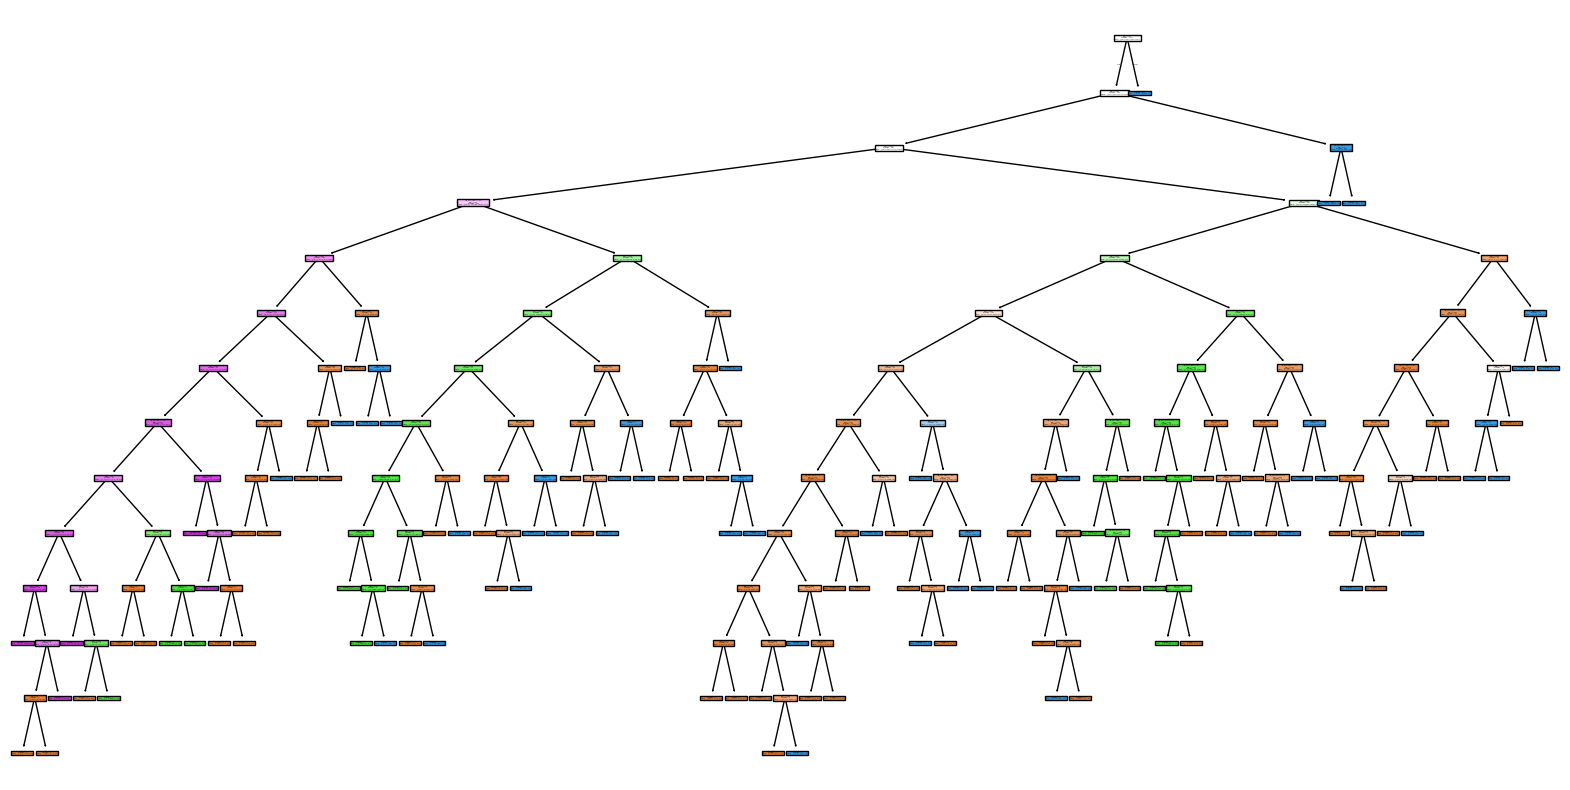

In [15]:
# display the decision tree
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(model, filled=True, feature_names=feature_names)